In [1]:
import os
import glob
import functools
from tqdm import tqdm

import numpy as np
import pandas as pd
import random

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

import torch
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
import torch.utils.data as data

import matplotlib.pyplot as plt

import nibabel as nib

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
%matplotlib inline

In [2]:
# import utils 
from viz_tools import plot_central_cuts
import data

## 0. Testing data loading for `Segmentation`

### 0.1 Dataset with FCD patients, data with `bb` segmented lesions - in `mask_path`.

  0%|          | 0/30 [00:00<?, ?it/s]

Assembling data for:  pirogov  sample.


100%|██████████| 30/30 [00:02<00:00, 11.29it/s]


Dataset size: 30
Labels distribution: (array([1]), array([30]))

Image shape: torch.Size([1, 192, 192, 192])
Segmentation shape: torch.Size([1, 192, 192, 192])


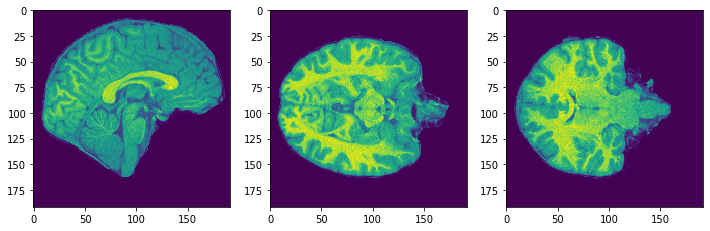

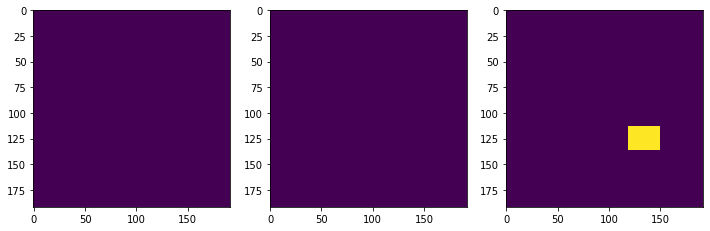

In [3]:
pirogov_data = data.MriSegmentation(sample='pirogov', mask='bb', ignore_missing=False,
                         coord_min=(30,30,30,), img_shape=(192, 192, 192,),
                         mask_path='/gpfs/gpfs0/sbi/data/fcd_classification_bank/masks',
                         image_path= '/gpfs/gpfs0/sbi/data/fcd_classification_bank',
                         targets_path= '../targets/targets_fcd_bank.csv')

print("Dataset size: {}".format(len(pirogov_data)))
print("Labels distribution: {}\n".format(np.unique(pirogov_data.target, return_counts=True)))
img, seg = pirogov_data[0]
print("Image shape: {}".format(img.shape))
print("Segmentation shape: {}".format(seg.shape))
plot_central_cuts(img)
plot_central_cuts(seg)

### 0.2 Dataset with FCD patient with `mri negative` lesions, to be predicted.

 13%|█▎        | 2/15 [00:00<00:01, 11.54it/s]

Assembling data for:  pirogov  sample.


100%|██████████| 15/15 [00:01<00:00, 11.50it/s]


Dataset size: 13
Labels distribution: (array([1]), array([13]))

Image shape: torch.Size([1, 192, 192, 192])
Segmentation shape: torch.Size([1, 192, 192, 192])


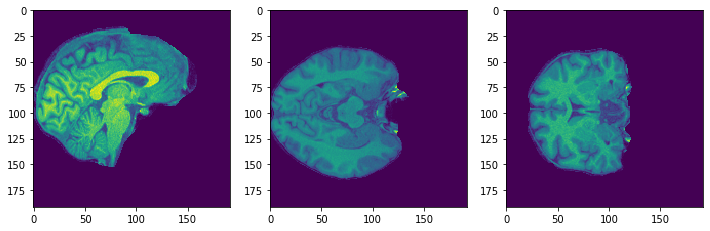

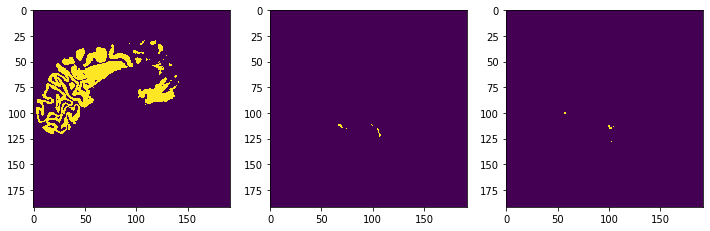

In [4]:
pirogov_data = data.MriSegmentation(sample='pirogov', prefix='no_fcd', mask='seg', 
                         image_path= '/gpfs/gpfs0/sbi/data/fcd_classification_bank',
                         targets_path= '../targets/targets_fcd_bank.csv')

print("Dataset size: {}".format(len(pirogov_data)))
print("Labels distribution: {}\n".format(np.unique(pirogov_data.target, return_counts=True)))
img, seg = pirogov_data[3]
print("Image shape: {}".format(img.shape))
print("Segmentation shape: {}".format(seg.shape))
plot_central_cuts(img)
plot_central_cuts(seg)

### 0.3 Dataset with no FCD patients, yet with other psychoneurological patologies

In [5]:
pd.read_csv('../targets/targets_fcd_bank.csv')['sample'].value_counts()

kulakov      480
hcp          441
la5_study    272
soloviev     181
pirogov       30
Name: sample, dtype: int64

  1%|          | 2/272 [00:00<00:16, 15.96it/s]

Assembling data for:  la5_study  sample.


100%|██████████| 272/272 [00:17<00:00, 15.58it/s]


Dataset size: 265
Labels distribution: (array([0]), array([265]))

Image shape: torch.Size([1, 192, 192, 192])
Segmentation shape: torch.Size([1, 192, 192, 192])


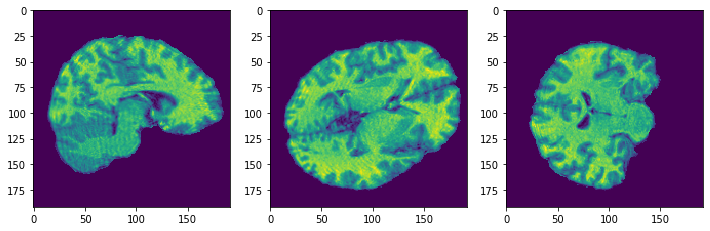

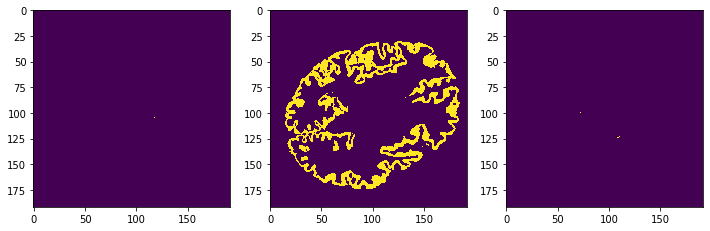

In [6]:
la5_data = data.MriSegmentation(sample='la5_study', 
                         image_path= '/gpfs/gpfs0/sbi/data/fcd_classification_bank',
#                          coord_min=(20,20,20,), img_shape=(200, 200, 200,),
                         targets_path= '../targets/targets_fcd_bank.csv')

print("Dataset size: {}".format(len(la5_data)))
print("Labels distribution: {}\n".format(np.unique(la5_data.target, return_counts=True)))
img, seg = la5_data[3]
print("Image shape: {}".format(img.shape))
print("Segmentation shape: {}".format(seg.shape))
plot_central_cuts(img)
plot_central_cuts(seg)

### 0.4 Dataset with both `control` and `focal epilepsy` patients

  1%|          | 2/181 [00:00<00:11, 15.04it/s]

Assembling data for:  soloviev  sample.


100%|██████████| 181/181 [00:11<00:00, 16.01it/s]


Dataset size: 180
Labels distribution: (array([0, 1]), array([90, 90]))

Image shape: torch.Size([1, 192, 192, 192])
Segmentation shape: torch.Size([1, 192, 192, 192])


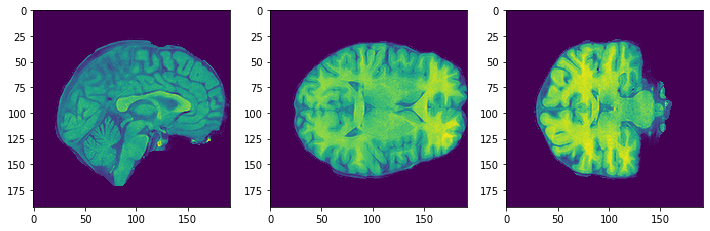

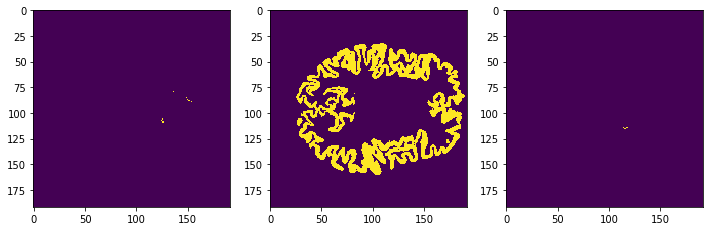

In [7]:
soloviev_data = data.MriSegmentation(sample='soloviev', 
                         image_path= '/gpfs/gpfs0/sbi/data/fcd_classification_bank',
#                          coord_min=(50,50,50,), img_shape=(180, 180, 180,),
                         targets_path= '../targets/targets_fcd_bank.csv')

print("Dataset size: {}".format(len(soloviev_data)))
print("Labels distribution: {}\n".format(np.unique(soloviev_data.target, return_counts=True)))
img, seg = soloviev_data[3]
print("Image shape: {}".format(img.shape))
print("Segmentation shape: {}".format(seg.shape))
plot_central_cuts(img)
plot_central_cuts(seg)

### 0.5 Dataset with only `epilepsy` patients, in 75% it is `FCD` patients

  0%|          | 2/480 [00:00<00:30, 15.85it/s]

Assembling data for:  kulakov  sample.


100%|██████████| 480/480 [00:30<00:00, 15.86it/s]


Dataset size: 421
Labels distribution: (array([1]), array([421]))

Image shape: torch.Size([1, 192, 192, 192])
Segmentation shape: torch.Size([1, 192, 192, 192])


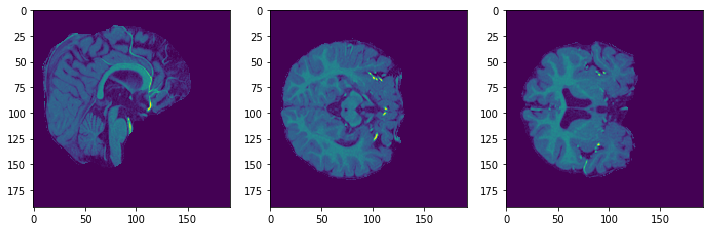

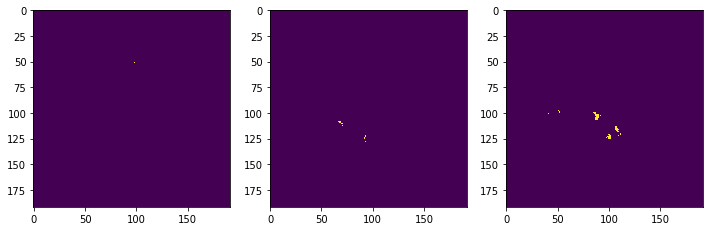

In [8]:
kulakov_data = data.MriSegmentation(sample='kulakov', 
                         image_path= '/gpfs/gpfs0/sbi/data/fcd_classification_bank',
#                          coord_min=(40,40,40,), img_shape=(180, 180, 180,),
                         targets_path= '../targets/targets_fcd_bank.csv')

print("Dataset size: {}".format(len(kulakov_data)))
print("Labels distribution: {}\n".format(np.unique(kulakov_data.target, return_counts=True)))
img, seg = kulakov_data[3]
print("Image shape: {}".format(img.shape))
print("Segmentation shape: {}".format(seg.shape))
plot_central_cuts(img)
plot_central_cuts(seg)

## 1.0 Testing data loading for `Classification`:

In [9]:
all_data = data.MriClassification(sample='soloviev', data_type = 'img', ignore_missing= False,
#                          coord_min=(30,30,30,), img_shape=(192, 192, 192,),
                         image_path= '/gpfs/gpfs0/sbi/data/fcd_classification_bank',
                         targets_path= '../targets/targets_fcd_bank.csv')

  1%|          | 2/181 [00:00<00:10, 16.30it/s]

Assembling data for:  soloviev  sample.


100%|██████████| 181/181 [00:11<00:00, 16.14it/s]


Image shape: torch.Size([1, 192, 192, 192])
Segmentation shape: torch.Size([1, 192, 192, 192])


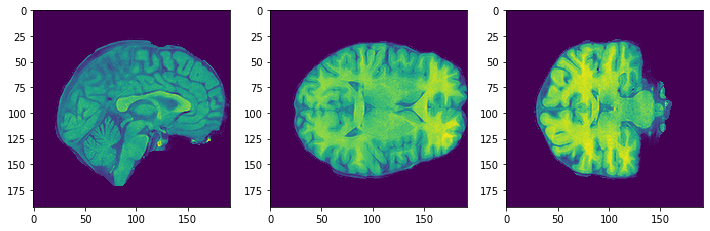

In [10]:
img = all_data[3]
print("Image shape: {}".format(img.shape))
print("Segmentation shape: {}".format(seg.shape))
plot_central_cuts(img)